# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from collections import Counter
from pprint import pprint

from tqdm.notebook import tqdm

import torch
from torch import functional as F
from torch import nn
from torch import optim

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


SEED = 42

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [2]:
class NegativeSampleCBOWBatcher:
    def __init__(
        self, corpus, window_size, batch_size, k,
        vocabulary_size=20000
    ):
        self.corpus = corpus
        self.window_size = window_size
        self.batch_size = batch_size
        self.k = k
        self.unk_token = '<UNK>'
        
        counts = sorted(
            Counter(self.corpus).items(),
            key=lambda x: x[1],
            reverse=True
        )[:vocabulary_size-1]
        
        counts_np = np.array([count for word, count in counts])
        
        freq = (counts_np/counts_np.sum())**0.75
        
        self.pvals = freq / freq.sum()
        
        self.word2index = {
            word: index for index, (word, _)
            in enumerate(counts)
        }
        
        self.word2index[self.unk_token] = len(self.word2index)
        self.index2word = {
            index: word for word, index in self.word2index.items()
        }
        
    def __iter__(self):
        self.permutation = np.random.permutation(
            np.arange(self.window_size, len(self.corpus) - self.window_size)
        )
        self.batch_number = 0
        return self
    
    def __next__(self):
        "return batch of (batch_size) positive samples and (k) negative samples"
        if self.batch_number < len(self.permutation) / self.batch_size:
            X = np.array(
                [
                    [
                        self.word2index.get(self.corpus[j], self.word2index[self.unk_token])
                        for j in range(i - self.window_size, i + self.window_size + 1)
                        if j != i
                    ] for i in self.permutation[self.batch_number * self.batch_size:
                                                (self.batch_number + 1) * self.batch_size]
                ]
            )
        
            y_pos = np.array(
                [
                    self.word2index.get(self.corpus[i], self.word2index[self.unk_token])
                    for i in self.permutation[self.batch_number * self.batch_size:
                                                (self.batch_number + 1) * self.batch_size]
                ]
            )
            
            y_neg = np.resize(
                np.random.multinomial(
                    self.k,
                    self.pvals,
                    size=X.shape[0]
                ).nonzero()[1],
                (X.shape[0], self.k)
            )
            
            self.batch_number += 1
            return X, y_pos, y_neg
        else:
            raise StopIteration

In [3]:
text = ['first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']
window_size = 2
batch_size = 4
k=5

batcher = NegativeSampleCBOWBatcher(text, window_size, batch_size, k)

In [4]:
def print_batch(X_batch, y_pos_batch, y_neg_batch):
    print('X_batch = ')
    print(X_batch)
    pprint([[batcher.index2word[x] for x in X] for X in X_batch])
    print()
    print('y_pos_batch = ', y_pos_batch)
    print([batcher.index2word[y_pos] for y_pos in y_pos_batch])
    print()
    print('y_neg_batch = ', y_neg_batch)
    pprint([[batcher.index2word[y_neg] for y_neg in y_neg_row] for y_neg_row in y_neg_batch])
    print()

for X_batch, y_pos_batch, y_neg_batch in batcher:
    print_batch(X_batch, y_pos_batch, y_neg_batch)

X_batch = 
[[1 2 4 5]
 [3 4 6 7]
 [0 1 3 4]
 [2 3 5 6]]
[['used', 'against', 'working', 'class'],
 ['early', 'working', 'radicals', 'including'],
 ['first', 'used', 'early', 'working'],
 ['against', 'early', 'class', 'radicals']]

y_pos_batch =  [3 5 2 4]
['early', 'class', 'against', 'working']

y_neg_batch =  [[0 1 5 6 0]
 [2 3 7 1 4]
 [6 7 2 4 5]
 [7 0 1 5 6]]
[['first', 'used', 'class', 'radicals', 'first'],
 ['against', 'early', 'including', 'used', 'working'],
 ['radicals', 'including', 'against', 'working', 'class'],
 ['including', 'first', 'used', 'class', 'radicals']]



In [5]:
with open('text8') as inf:
    corpus = inf.read().split()

In [6]:
class CBOWNetNegSample(nn.Module):
    def __init__(self, vocabulary_size, hidden_size):
        super().__init__()
        self.embedding1 = nn.Embedding(vocabulary_size, hidden_size)
        self.embedding2 = nn.Embedding(vocabulary_size, hidden_size)
    def forward(self, x, y_pos, y_neg):
        x_emb = self.embedding1(x).mean(dim=1)
        y_pos_emb = self.embedding2(y_pos)
        y_neg_emb = self.embedding2(y_neg)
        return x_emb, y_pos_emb, y_neg_emb

In [7]:
WINDOW_SIZE = 2
BATCH_SIZE = 1000
K = 5
VOCABULARY_SIZE = 5000
HIDDEN_SIZE = 300
LEARNING_RATE=1e-3
EPOCHS = 5
PATH = 'model_neg_sampling.pth'

batcher = NegativeSampleCBOWBatcher(corpus, WINDOW_SIZE, BATCH_SIZE, K, vocabulary_size=VOCABULARY_SIZE)

model = CBOWNetNegSample(VOCABULARY_SIZE, HIDDEN_SIZE).to(device)

criterion = nn.BCEWithLogitsLoss(reduction='sum')

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
)

steps_per_epoch = ceil((len(corpus) - 2 * WINDOW_SIZE) / BATCH_SIZE)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch
)

train_losses = []

t_epochs = tqdm(range(EPOCHS))
for epoch in t_epochs:
    avg_epoch_loss = 0
    t_batches = tqdm(
        enumerate(batcher),
        total=steps_per_epoch,
        leave=False
    )

    for i, (X_batch, y_pos_batch, y_neg_batch) in t_batches:
        X_batch_tensor = torch.from_numpy(X_batch).to(
            device=device, non_blocking=True
        )
        y_pos_batch_tensor = torch.from_numpy(y_pos_batch).to(
            device=device, non_blocking=True
        )
        y_neg_batch_tensor = torch.from_numpy(y_neg_batch).to(
            device=device, non_blocking=True
        )
        optimizer.zero_grad()
        logsigma, target = model(X_batch_tensor, y_pos_batch_tensor, y_neg_batch_tensor)
        loss = criterion(logsigma, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        avg_epoch_loss += loss.item() / (len(corpus) - 2 * WINDOW_SIZE)
        t_batches.set_postfix(loss=loss.item() / BATCH_SIZE)
        
    train_losses.append(avg_epoch_loss)
    t_epochs.set_postfix(avg_loss=avg_epoch_loss)

torch.save(model.state_dict(), PATH)

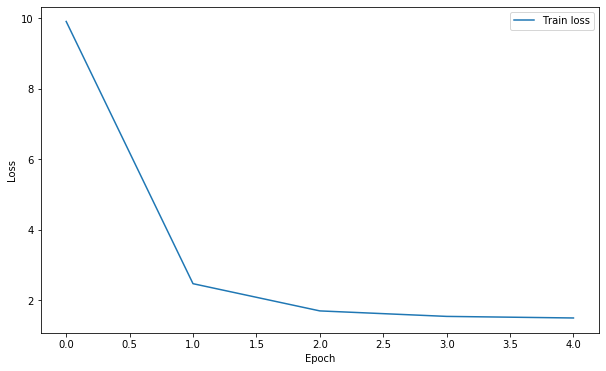

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [9]:
class Word2Vec:
    def __init__(self, word2index, embedding):
        self.word2index = word2index
        self.index2word = {
            index: word for word, index in self.word2index.items()
        }
        self.embedding = embedding
        self.unk_token = '<UNK>'
        self.similarity_matrix = cosine_similarity(embedding)
    def __getitem__(self, key):
        return self.embedding[
            self.word2index.get(key, self.word2index[self.unk_token])
        ]
    def most_similar(self, word):
        if word in self.word2index:
            indices = self.similarity_matrix[self.word2index[word]].argsort()[-2:-12:-1]
            return [self.index2word[i] for i in indices]
        else:
            return []
    def analogy(self, source_1, target_1, source_2):
        target_vector = self[target_1] - self[source_1] + self[source_2]
        indices = cosine_similarity(
            target_vector.reshape(1, -1), self.embedding
        )[0].argsort()[:-11:-1]
        return [self.index2word[i] for i in indices
                if self.index2word[i] not in [source_1, target_1, source_2] ][:10]
        

embedding = (model.embedding1.weight.detach() + model.embedding2.weight.detach()).cpu().numpy()

w2v = Word2Vec(batcher.word2index, embedding)

In [10]:
w2v.most_similar('linux')

['windows',
 'software',
 'gnu',
 'kernel',
 'unix',
 'dos',
 'server',
 'project',
 'os',
 'distribution']

In [11]:
embedding_reduced = TSNE(n_components=2).fit_transform(embedding)

In [12]:
def plot_embeddings(embedding_reduced, index2word, indices):
    plt.figure(figsize=(16, 10))
    for i in indices:
        plt.scatter(*embedding_reduced[i], marker='x', color='red')
        plt.text(*embedding_reduced[i], index2word[i], fontsize=9)
    plt.show()

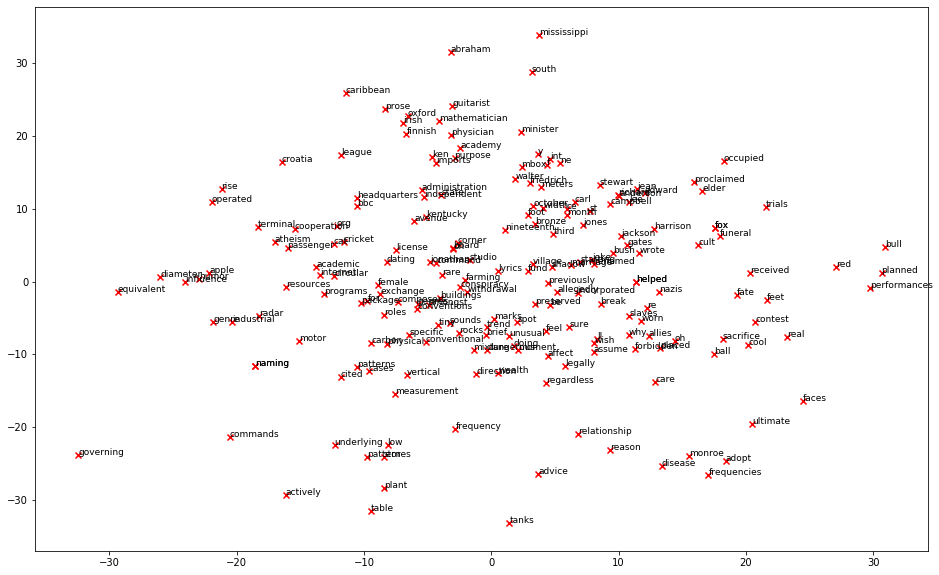

In [13]:
indices = np.random.randint(VOCABULARY_SIZE, size=200)
plot_embeddings(embedding_reduced, w2v.index2word, indices)